# MTL 3D Unet with 2 decoders: main_task ->2, aux_task ->3

## Data Prep

In [1]:
import torch
import monai
import torch.nn as nn
from pathlib import Path
import numpy as np
import random
from shutil import copyfile
import os
import nibabel as nib

# Set the random seed for reproducibility
random.seed(2022)

# Read all files ending with _img.nii
img_path = Path("data/data")
img_files = list(img_path.glob("*_img.nii")) # Image and mask are in the same folder
num_images = len(img_files) 

# Create train, validation and test splits
train_split = int(0.8 * num_images)
val_split = int(0.10 * num_images)
test_split = int(num_images - (train_split + val_split))

# Shuffle the image files
random.shuffle(img_files)

# Split the dataset
train_images = img_files[:train_split]
val_images = img_files[train_split:(train_split + val_split)]
test_images = img_files[(train_split + val_split): ]

# Create train, validation and test directories
train_image_dir = Path(img_path / "train_images")
train_mask_dir = Path(img_path / "train_masks")
val_image_dir = Path(img_path / "val_images")
val_mask_dir = Path(img_path / "val_masks")
test_image_dir = Path(img_path / "test_images")
test_mask_dir = Path(img_path / "test_masks")

# Create the directories if they don't exist
if not os.path.exists(train_image_dir) and not os.path.exists(train_mask_dir) and not os.path.exists(val_image_dir) and not os.path.exists(val_mask_dir) and not os.path.exists(test_image_dir) and not os.path.exists(test_mask_dir):
    for directory in [train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir]:
        directory.mkdir(exist_ok = True, parents = True)

    # Copy the images and their corresponding segmentation masks to their respective directories
    for directory, images in zip([train_image_dir, val_image_dir, test_image_dir], [train_images, val_images, test_images]):
        for image in images:
            # Copy image
            copyfile(image, directory / image.name)

            # Get corresponding segmentation mask
            mask = image.name.replace("_img.nii", "_mask.nii")

            # Copy segmentation mask
            copyfile(image.parent / mask, image.parent / directory.name.replace("images", "masks") / mask)


# # Sanity check
# train_images_s = list(train_image_dir.glob("*"))
# train_images_s = [image.name.removesuffix("_img.nii") for image in train_images_s]
# train_masks_s = list(train_mask_dir.glob("*"))
# train_masks_s = [mask.name.removesuffix("_mask.nii") for mask in train_masks_s]
# train_images_s == train_masks_s








## Create building blocks of the model

In [2]:
import torch
import torch.nn as nn
import torchvision


# Define a Residual block
class residual_block(nn.Module):
    """
    This class implements a residual block which consists of two convolution layers with group normalization
    """
    def __init__(self, in_channels, out_channels, n_groups = 8):
        super().__init__()
        # First convolution layer
        self.first_conv = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1, bias=False)
        self.first_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act1 = nn.SiLU() # Swish activation function

        # Second convolution layer
        self.second_conv = nn.Conv3d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1, bias = False)
        self.second_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act2 = nn.SiLU() # Swish activation function

        # Add dropout to the residual block
        self.dropout = nn.Dropout3d(p = 0.2)

        # If the number of input channels is not equal to the number of output channels,
        # then use a 1X1 convolution layer to compensate for the difference in dimensions
        # This allows the input to have the same dimensions as the output of the residual block
        if in_channels != out_channels:
            self.shortcut = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)
        else:
            # Pass the input as is
            self.shortcut = nn.Identity()

    # Pass the input through the residual block
    def forward(self, x):
        # Store the input
        input = x

        # Pass input through the first convolution layer
        x = self.act1(self.first_norm(self.first_conv(x)))

        # Pass the output of the first convolution layer through the second convolution layer
        x = self.act2(self.second_norm(self.second_conv(x)))

        # Add dropout
        x = self.dropout(x)


        # Add the input to the output of the second convolution layer
        # This is the skip connection
        x = x + self.shortcut(input)
        return x

# Implement the DownSample block that occurs after each residual block
class down_sample(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool3d(kernel_size = 2, stride = 2)

    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x

# Implement the UpSample block that occurs in the decoder path/expanding path
class up_sample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer to upsample the input
        self.up_sample = nn.ConvTranspose3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2, bias = False)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x

# Implement the crop and concatenate layer
class crop_and_concatenate(nn.Module):
    def forward(self, upsampled, bypass):
        # Crop the upsampled feature map to match the dimensions of the bypass feature map
        if upsampled.shape[2:] != bypass.shape[2:]:
            upsampled = nn.Upsample(size = bypass.shape[2:], mode="trilinear", align_corners=True)(upsampled)

        #upsampled = torchvision.transforms.functional.resize(upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

# Implement an attention block
class attention_block(nn.Module):
    def __init__(self, skip_channels, gate_channels, inter_channels = None, n_groups = 8):
        super().__init__()

        if inter_channels is None:
            inter_channels = skip_channels // 2

        # Implement W_g i.e the convolution layer that operates on the gate signal
        # Upsample gate signal to be the same size as the skip connection
        self.W_g = up_sample(in_channels = gate_channels, out_channels = skip_channels)
        self.W_g_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)
        self.W_g_act = nn.SiLU() # Swish activation function

        # Implement W_x i.e the convolution layer that operates on the skip connection
        self.W_x = nn.Conv3d(in_channels = skip_channels, out_channels = inter_channels, kernel_size = 1, padding = 0, bias = False)
        self.W_x_norm = nn.GroupNorm(num_groups = n_groups, num_channels = inter_channels)
        self.W_x_act = nn.SiLU() # Swish activation function

        # Implement phi i.e the convolution layer that operates on the output of W_x + W_g
        self.phi = nn.Conv3d(in_channels = inter_channels, out_channels = 1, kernel_size = 1, padding = 0, bias = False)
        #self.phi_norm = nn.GroupNorm(num_groups = n_groups, num_channels = 1)
        #self.phi_act = nn.SiLU() # Swish activation function

        # Implement the sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        # Implement the Swish activation function
        self.act = nn.SiLU()

        # Implement final group normalization layer
        self.final_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)

    # Pass the input through the attention block
    def forward(self, skip_connection, gate_signal):
        # Upsample the gate signal to match the channels of the skip connection
        gate_signal = self.W_g(gate_signal)
        # Ensure that the sizes of the skip connection and the gate signal match before addition
        if gate_signal.shape[2:] != skip_connection.shape[2:]:
            gate_signal = nn.Upsample(size = skip_connection.shape[2:], mode="trilinear", align_corners=True)(gate_signal)
            #gate_signal = torchvision.transforms.functional.resize(gate_signal, size = skip_connection.shape[2:], antialias=True)
        # Project to the intermediate channels
        gate_signal = self.W_x(gate_signal)

        # Project the skip connection to the intermediate channels
        skip_signal = self.W_x(skip_connection)

        # Add the skip connection and the gate signal
        add_xg = gate_signal + skip_signal

        # Pass the output of the addition through the activation function
        add_xg = self.act(add_xg)

        # Pass the output of attention through a 1x1 convolution layer to obtain the attention map
        attention_map = self.sigmoid(self.phi(add_xg))

        # Multiply the skip connection with the attention map
        # Perform element-wise multiplication
        skip_connection = torch.mul(skip_connection, attention_map)

        skip_connection = nn.Conv3d(in_channels = skip_connection.shape[1], out_channels = skip_connection.shape[1], kernel_size = 1, bias=False).to(device)(skip_connection)
        skip_connection = self.act(self.final_norm(skip_connection))

        return skip_connection

## Implement a 3D residual attention U-Net - Single head model that segments all 8 ROIs
class ResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups = 4, n_channels = [16, 32, 64, 128, 256]):
        super().__init__()

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, n_channels[0]), (n_channels[0], n_channels[1]), (n_channels[1], n_channels[2]), (n_channels[2], n_channels[3])])
        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(n_channels[3], n_channels[4])


        # Define the attention blocks
        self.attention_blocks = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])


        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                       [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                     [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv3d(in_channels = n_channels[0] , out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)

    # Pass the input through the residual attention U-Net
    def forward(self, x):
        # Store the skip connections
        skip_connections = []
       

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)
        
        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)
        

        # Initialize the attention block counter and the skip connection counter
        att_block_count = 0
        skip_connections_count = len(skip_connections)
    
        # Pass the output of the attention blocks through the expanding path
        for up_sample, concat, up_conv in zip(self.upsamples, self.concat, self.up_conv):
            gated_attn = self.attention_blocks[att_block_count](skip_connections[skip_connections_count - 1], x)
            att_block_count += 1
            skip_connections_count -= 1
            x = up_sample(x)
            x = concat(x, gated_attn)
            x = up_conv(x)

        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x

## Create the model

In [3]:
## Implement a MTL 3D resiidual attention U-Net in a more robust manner
class MTLResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, main_out_channels, aux_out_channels, n_channels = [32, 64, 128, 256, 512], gated_attention = False):
        super().__init__()
        
        # Choose whether to use gated attention or not
        self.gated_attention = gated_attention

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList()
        in_chans = in_channels
        for out_chans in n_channels[:-1]: # Skip the last element since it is the bottleneck
            self.down_conv.append(residual_block(in_chans, out_chans))
            in_chans = out_chans
        
        self.down_samples = nn.ModuleList(down_sample() for _ in range(len(n_channels) - 1))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(in_channels = n_channels[-2], out_channels = n_channels[-1])

        ## ------ Decoder block for segmenting main prostate zones: central, transition, background ------ ##
        # Define the attention blocks
        self.attention_blocks_main = nn.ModuleList()
        for gate_chans, residual_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.attention_blocks_main.append(attention_block(skip_channels = residual_chans, gate_channels = gate_chans))
        
        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples_main = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.upsamples_main.append(up_sample(in_chans, out_chans))
        
        self.concat_main = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        self.up_conv_main = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.up_conv_main.append(residual_block(in_chans, out_chans))

        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv_main = nn.Conv3d(in_channels = n_channels[0], out_channels = main_out_channels, kernel_size = 1, padding = 0, bias = False) # 


        ## ------ Decoder block for segmenting the auxilliary zones: Bladder, Rectum, Seminal vesicle, Neurovascular bundle ------ ##
        # Define the attention blocks
        self.attention_blocks_aux = nn.ModuleList()
        for gate_chans, residual_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.attention_blocks_aux.append(attention_block(skip_channels = residual_chans, gate_channels = gate_chans))

        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples_aux = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.upsamples_aux.append(up_sample(in_chans, out_chans))
        
        self.concat_aux = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        self.up_conv_aux = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.up_conv_aux.append(residual_block(in_chans, out_chans))

        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv_aux = nn.Conv3d(in_channels = n_channels[0], out_channels = aux_out_channels, kernel_size = 1, padding = 0, bias = False)


    # Pass the input through the residual attention U-Net
    # The input is a 5D tensor of shape (batch_size, channels, depth, height, width)
    def forward(self, x):
        # Store the skip connections
        skip_connections = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)

        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)

        # Define the main and auxilliary variables
        x_main = x
        x_aux = x

        # --- Pass the output of the encoder through the decoder of the main prostate zones --- #
        # Initialize the attention block counter and the skip connection counter
        attn_block_count = 0
        skip_connections_count = len(skip_connections)

        # Pass the output of the attention blocks through the expanding path
        if self.gated_attention:
            for up_sample, concat, up_conv in zip(self.upsamples_main, self.concat_main, self.up_conv_main):
                gated_attn = self.attention_blocks_main[attn_block_count](skip_connections[skip_connections_count - 1], x_main)
                attn_block_count += 1
                skip_connections_count -= 1
                x_main = up_sample(x_main)
                x_main = concat(x_main, gated_attn)
                x_main = up_conv(x_main)
        else:
            for up_sample, concat, up_conv in zip(self.upsamples_main, self.concat_main, self.up_conv_main):
                x_main = up_sample(x_main)
                x_main = concat(x_main, skip_connections[skip_connections_count - 1])
                x_main = up_conv(x_main)
                skip_connections_count -= 1
        
        # Pass the output of the main decoder through the final convolution layer
        x_main = self.final_conv_main(x_main)  # Output segmentation map for the main prostate zones

        # --- Pass the output of the encoder through the decoder of the auxilliary prostate zones --- #
        # Initialize the attention block counter and the skip connection counter
        attn_block_count = 0
        skip_connections_count = len(skip_connections)

        # Pass the output of the attention blocks through the expanding path
        if self.gated_attention:
            for up_sample, concat, up_conv in zip(self.upsamples_aux, self.concat_aux, self.up_conv_aux):
                gated_attn = self.attention_blocks_aux[attn_block_count](skip_connections[skip_connections_count - 1], x_aux)
                attn_block_count += 1
                skip_connections_count -= 1
                x_aux = up_sample(x_aux)
                x_aux = concat(x_aux, gated_attn)
                x_aux = up_conv(x_aux)
        else:
            for up_sample, concat, up_conv in zip(self.upsamples_aux, self.concat_aux, self.up_conv_aux):
                x_aux = up_sample(x_aux)
                x_aux = concat(x_aux, skip_connections[skip_connections_count - 1])
                x_aux = up_conv(x_aux)
                skip_connections_count -= 1
            
        # Pass the output of the auxilliary decoder through the final convolution layer
        x_aux = self.final_conv_aux(x_aux) # Output segmentation map for the auxilliary prostate zones

        # Return the output segmentation maps for the main and auxilliary prostate zones
        return x_main, x_aux

# Test whether the model is working
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# modelt = MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = 3, aux_out_channels = 4, n_channels = [32, 64, 128, 256, 512], gated_attention = False).to(device)
# x = torch.randn(2, 1, 40, 128, 128).to(device)
# x_main, x_aux = modelt(x)
# x_main.shape, x_aux.shape




        



## Define Data Augmentation

In [4]:
#!pip install monai
from monai.utils import first, set_determinism 
from monai.transforms import (
    EnsureChannelFirstd, # Adjust or add the channel dimension of input data to ensure channel_first shape.
    #AddChanneld,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    ScaleIntensityd,
    Spacingd,
    SpatialPadd,
    ToTensord,
    RandAffined, Resized, RandSpatialCropd,
    CropForegroundd, # Crop the foreground region of the input image based on the provided mask to help training and evaluation if the valid part is small in the whole medical image
    RandCropByPosNegLabeld, # Crop random patches from image and label based on positive / negative label ratio.
    RandGaussianNoised, # Randomly add Gaussian noise to image.
    RandGaussianSmoothd, # Randomly smooth image with Gaussian filter.
    AdjustContrastd, # Adjust image contrast by gamma value.

)

# Set deterministic training for reproducibility
set_determinism(seed = 2056)

# Put the train images and masks in a dictionary
train_images = sorted(train_image_dir.glob("*"))
train_masks = sorted(train_mask_dir.glob("*"))
train_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(train_images, train_masks)]

# Put the validation images and masks in a dictionary
val_images = sorted(val_image_dir.glob("*"))
val_masks = sorted(val_mask_dir.glob("*"))
val_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(val_images, val_masks)]

# Put the test images and masks in a dictionary
test_images = sorted(test_image_dir.glob("*"))
test_masks = sorted(test_mask_dir.glob("*"))
test_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(test_images, test_masks)]

# Create transforms for training
train_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        CropForegroundd(keys = ["image", "mask"], source_key = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"), # Interpolation mode for image and mask
        ),
        # RandCropByPosNegLabeld(
        #     keys = ["image", "mask"],
        #     label_key = "mask",
        #     spatial_size = (256, 256, 40), # Output size of the image [height, width, depth]
        #     pos = 1, # Ratio of positive labels in the output image
        #     neg = 1, # Ratio of negative labels in the output image
        #     num_samples = 4, # Number of random crops
        #     image_key = "image", # Key of the image to be cropped
        #     image_threshold = 0# Threshold to determine the foreground of the image
        # ),
        RandAffined(
            keys = ["image", "mask"],
            mode = ("bilinear", "nearest"),
            prob = 1.0,
            spatial_size = (256, 256, 40), # Output size of the image [height, width, depth]
            rotate_range = (np.pi / 36, np.pi / 36, np.pi / 36), # Rotation range
            scale_range = (0.1, 0.1, 0.1), # will do [-0.1, 0.1] scaling then add 1 so a scaling in the range [0.9, 1.1]
            padding_mode="zeros", # This means that the image will be padded with zeros, some images are smaller than 256x256x40
        ),
        RandGaussianNoised(
            keys = "image",
            prob = 0.15,
            mean = 0.0,
            std = 0.1

        ),
        RandGaussianSmoothd(
            keys = "image",
            prob = 0.1,
            sigma_x=(0.5, 1.5),
            sigma_y=(0.5, 1.5),
            sigma_z=(0.5, 1.5)
        ),
        AdjustContrastd(
            keys = "image",
            gamma = 1.3
        )



        
    ]
)

# Create transforms for validation
val_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        CropForegroundd(keys = ["image", "mask"], source_key = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"),
        ),
        # since we are not doing data augmentation during validation,
        #we simply center crop the image and mask to the specified size of [256, 256, 40]
        CenterSpatialCropd(keys = ["image", "mask"], roi_size = (256, 256, 40)), 
        SpatialPadd(keys = ["image", "mask"], spatial_size= (256, 256, 40)) # Some images are smaller than 256x256x40, so we pad them to this size


        

    ]
)

In [5]:
organs = ["Background", "Bladder", "Bone", "Obturator internus", "Transition zone", "Central gland",
          "Rectum", "Seminal vesicle", "Neurovascular bundle"]
# Create an index dictionary
organs_dict = {organ: idx for idx, organ in enumerate(organs)}
organs_dict

{'Background': 0,
 'Bladder': 1,
 'Bone': 2,
 'Obturator internus': 3,
 'Transition zone': 4,
 'Central gland': 5,
 'Rectum': 6,
 'Seminal vesicle': 7,
 'Neurovascular bundle': 8}

In [20]:
# torch.cuda.empty_cache()
# from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
# #from tqdm import tqdm
# BATCH_SIZE = 2
# #train_ds = CacheDataset(data = train_files, transform = train_transforms, cache_rate = 1.0, num_workers = 4)
# train_ds = Dataset(data = val_files, transform = train_transforms)
# train_dl = DataLoader(dataset = train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

# #val_ds = CacheDataset(data = val_files, transform = val_transforms, cache_rate = 1.0, num_workers = 4)
# val_ds = Dataset(data = train_files, transform = val_transforms)
# val_dl = DataLoader(dataset = val_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)

In [6]:
torch.cuda.empty_cache()
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
#from tqdm import tqdm
BATCH_SIZE = 2
#train_ds = CacheDataset(data = train_files, transform = train_transforms, cache_rate = 1.0, num_workers = 4)
train_ds = Dataset(data = train_files, transform = train_transforms)
train_dl = DataLoader(dataset = train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

#val_ds = CacheDataset(data = val_files, transform = val_transforms, cache_rate = 1.0, num_workers = 4)
val_ds = Dataset(data = val_files, transform = val_transforms)
val_dl = DataLoader(dataset = val_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)

In [7]:
len(train_dl), len(val_dl)

(236, 29)

In [19]:
# # # Load a trained model
# # # Instantiate model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = main_out_channels , aux_out_channels = aux_out_channels, n_channels = [32, 64, 128, 256, 512], gated_attention = True).to(device)#Main: 2 structures + background, Aux: 3 structures + background

# # # Load the state dictionary of the model
# model.load_state_dict(torch.load("models/main_2_aux_3_pytorch_male_pelvic_segmentation_model.pth"))

<All keys matched successfully>

In [ ]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

lr = 5e-4
max_epochs = 100
main_out_channels = 3 # Number of structures 2 + background
aux_out_channels = 4 # Number of structures 3 + background

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Input image has eight anatomical structures of planning interest
#model = MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = main_out_channels , aux_out_channels = aux_out_channels, n_channels = [32, 64, 128, 256, 512], gated_attention = True).to(device)#Main: 2 structures + background, Aux: 3 structures + background
loss_function = DiceLoss(to_onehot_y = True, softmax = True, include_background=False) # For segmentation Expects BNHW[D] input i.e. batch, channel, height, width, depth, performs softmax on the channel dimension to get a probability distribution
optimizer = torch.optim.Adam(model.parameters(), lr) # Decreased the loss after getting a somewhat good model
dice_metric_main = DiceMetric(include_background=False, reduction="mean")# Collect the loss and metric values for every iteration
dice_metric_aux = DiceMetric(include_background=False, reduction="mean")
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min = 1e-6) #** Adopt a cosine annealing learning rate schedule which reduces the learning rate as the training progresses


In [24]:
# Import AsDiscrete transform to convert the output to discrete values
#from skimage.metrics import structural_similarity as ssim
from monai.transforms import AsDiscrete
from pathlib import Path
# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "main_2_aux_3_pytorch_male_pelvic_segmentation_model_final.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


val_interval = 10
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_aux_loss_values = []
epoch_total_loss_values = []
main_metric_values = []
aux_metric_values = []

# Post transforms for the main prostate zones: 2 classes + background
post_pred_transform_main = Compose([AsDiscrete(argmax = True, to_onehot = main_out_channels)])
post_label_transform_main = Compose([AsDiscrete(to_onehot = main_out_channels)])

# Post transforms for the auxilliary prostate zones: 3 classes + background
post_pred_transform_aux = Compose([AsDiscrete(argmax = True, to_onehot = aux_out_channels)])
post_label_transform_aux = Compose([AsDiscrete(to_onehot = aux_out_channels)])

# Loss weights
main_weight = 1.5
aux_weight = 1.1

#CUDA_LAUNCH_BLOCKING=1


for epoch in range(max_epochs):
    print("-" * 20)
    print(f"Epoch {epoch + 1} / {max_epochs}")
    # Put the model into training mode
    model.train()
    epoch_loss = 0
    epoch_aux_loss = 0
    epoch_total_loss = 0
    step = 0
    for batch in train_dl:
        step = step + 1
        inputs = batch["image"].permute(0, 1, 4, 2, 3).to(device)
        labels = batch["mask"].to(device) # Permute beccause of torch upsample

        # Modify the main labels to match the output of the main decoder
        main_labels = labels.clone()
        main_labels[(main_labels != organs_dict['Transition zone']) & (main_labels != organs_dict['Central gland'])] = 0.0
        main_labels[main_labels == organs_dict['Transition zone']] = 1.0
        main_labels[main_labels == organs_dict['Central gland']] = 2.0

        # Modify the auxilliary labels to match the output of the auxilliary decoder
        aux_labels = labels.clone()
        aux_labels[(aux_labels != organs_dict['Bladder']) & (aux_labels != organs_dict['Rectum']) & (aux_labels != organs_dict['Seminal vesicle'])] = 0.0
        aux_labels[aux_labels == organs_dict['Bladder']] = 1.0
        aux_labels[aux_labels == organs_dict['Rectum']] = 2.0
        aux_labels[aux_labels == organs_dict['Seminal vesicle']] = 3.0

        
    


        # Forward pass
        main_seg, aux_seg = model(inputs) 
        main_seg, aux_seg = main_seg.permute(0, 1, 3, 4, 2), aux_seg.permute(0, 1, 3, 4, 2) # Permute back to BNHWD

        # Compute the loss functions
        main_seg_loss = loss_function(main_seg, main_labels)
        aux_seg_loss = loss_function(aux_seg, aux_labels)

        # Compute the total loss
        loss = main_weight * main_seg_loss + aux_weight * aux_seg_loss

        # Zero the gradients
        optimizer.zero_grad()

        # Find the gradients of the loss w.r.t the model parameters
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Add the loss to the epoch loss
        epoch_loss = epoch_loss + main_seg_loss.item()
        epoch_aux_loss = epoch_aux_loss + aux_seg_loss.item()
        epoch_total_loss = epoch_total_loss + loss.item()
    # Compute the average loss of the epoch
    epoch_loss = epoch_loss / step
    epoch_aux_loss = epoch_aux_loss / step
    epoch_total_loss = epoch_total_loss / step
    epoch_loss_values.append(epoch_loss)
    epoch_total_loss_values.append(epoch_total_loss)
    epoch_aux_loss_values.append(epoch_aux_loss)


    # Print the average loss of the epoch
    print(f"\nEpoch {epoch + 1} average dice loss for main task: {epoch_loss:.4f}")
    print(f"\nEpoch {epoch + 1} average dice loss for aux task: {epoch_aux_loss:.4f}")
    print(f"\nEpoch {epoch + 1} average total loss for both tasks: {epoch_total_loss:.4f}")

    # Step the scheduler after every epoch
    scheduler.step()

    # Print loss and evaluate model when epoch is divisible by val_interval
    if (epoch + 1) % val_interval == 0:
        #print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        # Put the model into evaluation mode
        model.eval()
        # Disable gradient calculation
        with torch.inference_mode():
            # Loop through the validation data
            for val_data in val_dl:
                val_inputs, val_labels = val_data["image"].permute(0, 1, 4, 2, 3).to(device), val_data["mask"].to(device)
                # Modify the main labels to match the output of the main decoder
                val_main_labels = val_labels.clone()
                val_main_labels[(val_main_labels != organs_dict['Transition zone']) & (val_main_labels != organs_dict['Central gland'])] = 0.0
                val_main_labels[val_main_labels == organs_dict['Transition zone']] = 1.0
                val_main_labels[val_main_labels == organs_dict['Central gland']] = 2.0

                # Modify the auxilliary labels to match the output of the auxilliary decoder
                val_aux_labels = val_labels.clone()
                val_aux_labels[(val_aux_labels != organs_dict['Bladder']) & (val_aux_labels != organs_dict['Rectum']) & (val_aux_labels != organs_dict['Seminal vesicle'])] = 0.0
                val_aux_labels[val_aux_labels == organs_dict['Bladder']] = 1.0
                val_aux_labels[val_aux_labels == organs_dict['Rectum']] = 2.0
                val_aux_labels[val_aux_labels == organs_dict['Seminal vesicle']] = 3.0



                # Forward pass
                val_main_outputs, val_aux_outputs = model(val_inputs)
                val_main_outputs, val_aux_outputs = val_main_outputs.permute(0, 1, 3, 4, 2), val_aux_outputs.permute(0, 1, 3, 4, 2)

                # Transform main outputs and labels to calculate inference loss
                val_main_outputs = [post_pred_transform_main(i) for i in decollate_batch(val_main_outputs)]
                val_main_labels = [post_label_transform_main(i) for i in decollate_batch(val_main_labels)]

                # Transform aux outputs and labels to calculate inference loss
                val_aux_outputs = [post_pred_transform_aux(i) for i in decollate_batch(val_aux_outputs)]
                val_aux_labels = [post_label_transform_aux(i) for i in decollate_batch(val_aux_labels)]


                # Compute dice metric for current iteration
                dice_metric_main(y_pred = val_main_outputs, y = val_main_labels)
                dice_metric_aux(y_pred = val_aux_outputs, y = val_aux_labels)

            # Compute the average metric value across all iterations
            main_metric = dice_metric_main.aggregate().item()
            aux_metric = dice_metric_aux.aggregate().item()
            main_metric_values.append(main_metric)
            aux_metric_values.append(aux_metric)
            
            # Reset the metric for next validation run
            dice_metric_main.reset()
            dice_metric_aux.reset()


            # If the metric is better than the best seen so far, save the model
            if main_metric > best_metric:
                best_metric = main_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                print("saved new best metric model")
            
            print(
                f"\nCurrent epoch: {epoch + 1} current mean dice for main task: {main_metric:.4f}"
                f"\nBest mean dice for main task: {best_metric:.4f} at epoch: {best_metric_epoch}"
                f"\nCurrent epoch: {epoch + 1} current mean dice for aux task: {aux_metric:.4f}"
                )
            

# When training is complete:
print(f"Done training! Best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

                


--------------------
Epoch 1 / 100


d:\Eric\multi_task_learning\ml_cw2\multi_task_learning\.venv\lib\site-packages\monai\data\__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)



Epoch 1 average dice loss for main task: 0.2260

Epoch 1 average dice loss for aux task: 0.1987

Epoch 1 average total loss for both tasks: 0.5576
--------------------
Epoch 2 / 100

Epoch 2 average dice loss for main task: 0.2128

Epoch 2 average dice loss for aux task: 0.1914

Epoch 2 average total loss for both tasks: 0.5298
--------------------
Epoch 3 / 100

Epoch 3 average dice loss for main task: 0.2036

Epoch 3 average dice loss for aux task: 0.1840

Epoch 3 average total loss for both tasks: 0.5077
--------------------
Epoch 4 / 100

Epoch 4 average dice loss for main task: 0.2028

Epoch 4 average dice loss for aux task: 0.1731

Epoch 4 average total loss for both tasks: 0.4946
--------------------
Epoch 5 / 100

Epoch 5 average dice loss for main task: 0.1990

Epoch 5 average dice loss for aux task: 0.1698

Epoch 5 average total loss for both tasks: 0.4854
--------------------
Epoch 6 / 100

Epoch 6 average dice loss for main task: 0.1993

Epoch 6 average dice loss for aux t

1. Trained model on half resolution
2. Decreased LR and trained a bit more
3. Use higher resolution
4. Decrease LR and train a bit more
Model2: Best

In [12]:
# Save epoch loss and metric values based on the model name
import pickle
pref = f"{MODEL_NAME.split('.')[0]}"
with open(MODEL_PATH/f"{pref}_epoch_loss_values.pkl", "wb") as f:
    pickle.dump(epoch_loss_values, f)
with open(MODEL_PATH/f"{pref}_epoch_aux_loss_values.pkl", "wb") as f:
    pickle.dump(epoch_aux_loss_values, f)
with open(MODEL_PATH/f"{pref}_epoch_total_loss_values.pkl", "wb") as f:
    pickle.dump(epoch_total_loss_values, f)
with open(MODEL_PATH/f"{pref}_main_metric_values.pkl", "wb") as f:
    pickle.dump(main_metric_values, f)
with open(MODEL_PATH/f"{pref}_aux_metric_values.pkl", "wb") as f:
    pickle.dump(aux_metric_values, f)

# # Open the saved files
# with open(MODEL_PATH/"epoch_loss_values.pkl", "rb") as f:
#     epoch_loss_values = pickle.load(f)
# with open(MODEL_PATH/"metric_values.pkl", "rb") as f:
#     metric_values = pickle.load(f)

## Plot the loss and metric per epoch

In [15]:
len(epoch_loss_values), epoch_loss_values[:5]

(100,
 [0.7047474092598689,
  0.4884043577111373,
  0.41969291588007396,
  0.3899679638571658,
  0.35980865352992286])

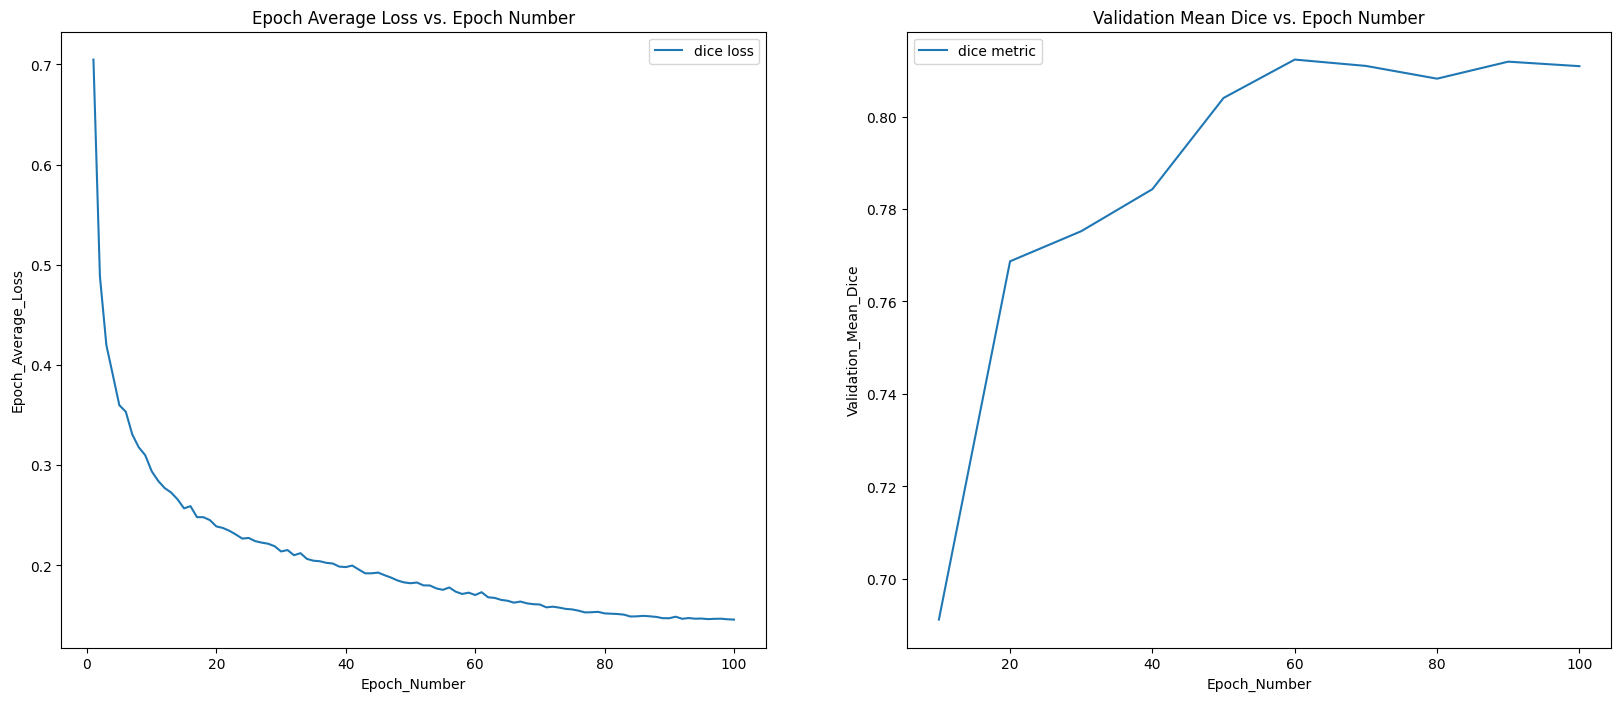

In [16]:
import matplotlib.pyplot as plt
# Load the saved values
import pickle
MODEL_PATH = Path("models")
pref = f"{MODEL_NAME.split('.')[0]}"
with open(MODEL_PATH/f"{pref}_epoch_loss_values.pkl", "rb") as f:
    epoch_loss_values = pickle.load(f)
with open(MODEL_PATH/f"{pref}_epoch_aux_loss_values.pkl", "rb") as f:
    epoch_aux_loss_values = pickle.load(f)
with open(MODEL_PATH/f"{pref}_epoch_total_loss_values.pkl", "rb") as f:
    epoch_total_loss_values = pickle.load(f)
with open(MODEL_PATH/f"{pref}_main_metric_values.pkl", "rb") as f:
    main_metric_values = pickle.load(f)
with open(MODEL_PATH/f"{pref}_aux_metric_values.pkl", "rb") as f:
    aux_metric_values = pickle.load(f)

import matplotlib.pyplot as plt
# Plot the loss and metric values
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss vs. Epoch Number")
x = np.arange(1, len(epoch_loss_values)+1)
y = epoch_loss_values
plt.plot(x.tolist(), y, label = "dice loss")
plt.xlabel('Epoch_Number')
plt.ylabel('Epoch_Average_Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice vs. Epoch Number")
x = np.arange(1, len(main_metric_values)+1) * val_interval
y = main_metric_values
plt.plot(x.tolist(), y, label = "dice metric")
plt.xlabel('Epoch_Number')
plt.ylabel('Validation_Mean_Dice')
plt.legend()
plt.show()

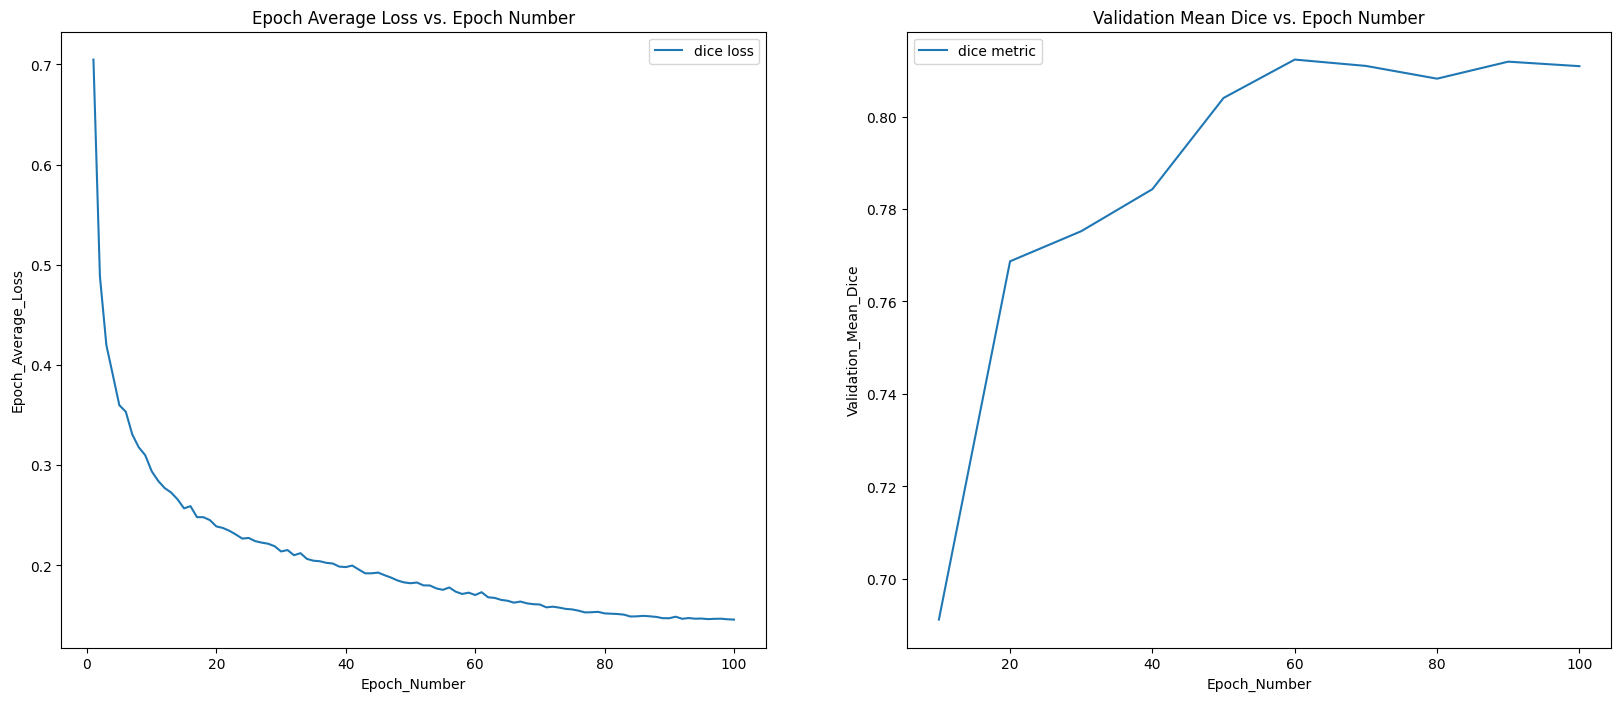

In [13]:
import matplotlib.pyplot as plt
# Plot the loss and metric values
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss vs. Epoch Number")
x = np.arange(1, len(epoch_loss_values)+1)
y = epoch_loss_values
plt.plot(x.tolist(), y, label = "dice loss")
plt.xlabel('Epoch_Number')
plt.ylabel('Epoch_Average_Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice vs. Epoch Number")
x = np.arange(1, len(main_metric_values)+1) * val_interval
y = main_metric_values
plt.plot(x.tolist(), y, label = "dice metric")
plt.xlabel('Epoch_Number')
plt.ylabel('Validation_Mean_Dice')
plt.legend()
plt.show()

## Perform inference on the test set

In [8]:
# Setup
from monai.metrics import DiceMetric
# Import AsDiscrete transform to convert the output to discrete values
#from skimage.metrics import structural_similarity as ssim
from monai.transforms import AsDiscrete
from pathlib import Path


main_out_channels = 3 # Number of structures 2 + background
aux_out_channels = 4 # Number of structures 3 + background

# Create model directory
MODEL_PATH = Path("models")
MODEL_NAME = "main_2_aux_3_pytorch_male_pelvic_segmentation_model.pth"
BATCH_SIZE_TEST = 2 # batcH size of 1 to evaluate one image at a time

# Evaluation metrics
dice_metric_main = DiceMetric(include_background=False, reduction="mean")# Collect the loss and metric values for every iteration
dice_metric_aux = DiceMetric(include_background=False, reduction="mean")


In [9]:

# Create transforms for test images during forwrad pass
test_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        CropForegroundd(keys = ["image", "mask"], source_key = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"),
        ),
        CenterSpatialCropd(keys = ["image", "mask"], roi_size = (256, 256, 40)),
        SpatialPadd(keys = ["image", "mask"], spatial_size = (256, 256, 40))

    ])

# Create post transforms for results of forward pass
post_pred_transform_main = Compose([AsDiscrete(argmax = True, to_onehot = main_out_channels)])
post_label_transform_main = Compose([AsDiscrete(to_onehot = main_out_channels)])

# Post transforms for the auxilliary prostate zones: 3 classes + background
post_pred_transform_aux = Compose([AsDiscrete(argmax = True, to_onehot = aux_out_channels)])
post_label_transform_aux = Compose([AsDiscrete(to_onehot = aux_out_channels)])

# Create test dataset to apply transforms to test images
test_ds = Dataset(data = test_files, transform = test_transforms)

# Create test dataloader to load images in batches
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE_TEST, shuffle = False, num_workers = 4)

# Load the best saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = main_out_channels , aux_out_channels = aux_out_channels, n_channels = [32, 64, 128, 256, 512], gated_attention = True).to(device)
model.load_state_dict(torch.load(MODEL_PATH/MODEL_NAME))


<All keys matched successfully>

In [10]:

# Set model to eval mode
model.eval()

# Inference loop
with torch.inference_mode(): # Disaable gradient tracking
    dice_metric_main.reset()
    dice_metric_aux.reset()

    for test_data in test_dl:
        test_inputs, test_labels = test_data["image"].permute(0, 1, 4, 2, 3).to(device), test_data["mask"].to(device)
        # Modify the main labels to match output of main decoder
        test_main_labels = test_labels.clone()
        test_main_labels[(test_main_labels != organs_dict['Transition zone']) & (test_main_labels != organs_dict['Central gland'])] = 0.0
        test_main_labels[test_main_labels == organs_dict['Transition zone']] = 1.0
        test_main_labels[test_main_labels == organs_dict['Central gland']] = 2.0

        # # Modify the aux labels to match output of aux decoder
        # test_aux_labels = test_labels.clone()
        # test_aux_labels[(test_aux_labels != organs_dict['Bladder']) & (test_aux_labels != organs_dict['Rectum']) & (test_aux_labels != organs_dict['Seminal vesicle'])] = 0.0
        # test_aux_labels[test_aux_labels == organs_dict['Bladder']] = 1.0
        # test_aux_labels[test_aux_labels == organs_dict['Rectum']] = 2.0
        # test_aux_labels[test_aux_labels == organs_dict['Seminal vesicle']] = 3.0

        # Forward pass
        test_main_outputs, test_aux_outputs = model(test_inputs)
        test_main_outputs, test_aux_outputs = test_main_outputs.permute(0, 1, 3, 4, 2), test_aux_outputs.permute(0, 1, 3, 4, 2)

        # Post transform the outputs and labels before making inference
        test_main_outputs = [post_pred_transform_main(i) for i in decollate_batch(test_main_outputs)]
        test_main_labels = [post_label_transform_main(i) for i in decollate_batch(test_main_labels)]

        # test_aux_outputs = [post_pred_transform_aux(i) for i in decollate_batch(test_aux_outputs)]
        # test_main_labels = [post_label_transform_aux(i) for i in decollate_batch(test_aux_labels)]

        # Compute dice metric for the curent iteration
        dice_metric_main(y_pred = test_main_outputs, y = test_main_labels)
        #dice_metric_aux(y_pred = test_aux_outputs, y = test_aux_labels)
    

    # Obtain the metric values for class 1 (Transition zone) and class 2 (Central gland), class 0 is background is ignored
    test_dice_scores = {'Transition zone': dice_metric_main.get_buffer()[:, 0].cpu().numpy().tolist(),
                        'Central gland': dice_metric_main.get_buffer()[:, 1].cpu().numpy().tolist()}

    # Aggregate the final mean dice result
    test_metric = dice_metric_main.aggregate().item()
    #test_metric_aux = dice_metric_aux.aggregate().item()
    #dice_metric_main.reset()
    #dice_metric_aux.reset()

print(f"Test Mean Dice: {test_metric:.4f}")

# Save the test dice scores to a pickle file
import pickle
pref = f"{MODEL_NAME.split('.')[0]}"
with open(MODEL_PATH/f"{pref}_test_dice_scores.pkl", "wb") as f:
    pickle.dump(test_dice_scores, f)

# To load the pickle file
# with open(MODEL_PATH/f"{pref}_test_dice_scores.pkl", "rb") as f:
#     test_dice_scores = pickle.load(f)


# (np.mean(test_dice_scores["Central gland"]) + np.mean(test_dice_scores["Transition zone"]))/2 : mean of the dice scores of the two classes


d:\Eric\multi_task_learning\ml_cw2\multi_task_learning\.venv\lib\site-packages\monai\data\__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)


Test Mean Dice: 0.8065
